In [ ]:
# Instalando bibliotecas 
!pip install --upgrade tweepy
!pip install --upgrade networkx

In [ ]:
# Importando biblioteca de acesso a API do Twitter
import tweepy as tw
#tw.__version__   aaa sb
import pytz
import datetime
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [ ]:
# Autenticando na API do Twitter

# Dados de Autenticação
# Caso ainda não tenha acesso a API do Twitter acesse essa página:
# https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAKtckwEAAAAAYV8r7pZHTOzX%2F1ZH7dywUUELKxU%3DfuB1CZ6BYXp8S0Jjf2md95jIifYwCLrc875I0Zt9kp5cNOsd6S' # Bear token pego com a conta do bandeijao unirio

# Autenticando
client = tw.Client(bearer_token)

In [ ]:
# Configurando a Pesquisa
query = "Lula  lang:pt"
data_inicio = "2023-01-01 14:00:00"
data_fim = "2023-01-01 14:30:00"

def converteData(data):
    # Formato esperado de data "2000-1-1 12:00:00"
    local_time = pytz.timezone("America/Sao_Paulo")
    utc_data = local_time.localize(datetime.datetime.strptime(data, "%Y-%m-%d %H:%M:%S"), is_dst=None).astimezone(pytz.utc)
    dtformat = '%Y-%m-%dT%H:%M:%SZ'
    time = datetime.datetime.utcnow()
    return utc_data.strftime(dtformat)

In [ ]:
# Extraindo os Tweets

response_tweets = client.search_recent_tweets(query, max_results=100,start_time=converteData(data_inicio), end_time=converteData(data_fim),
                                       user_fields=['id'], expansions=['author_id'], tweet_fields=['created_at'])
print(response_tweets)

In [ ]:

# Convertendo a saída em Dataframe para melhor visualização

df_tweets_extraidos = pd.DataFrame.from_dict(response_tweets.data)
df_tweets_extraidos.head(10)

In [ ]:
# Contagem dos Tweets disponiveis na query pesquisada
response_contagem = client.get_recent_tweets_count(query, start_time=converteData(data_inicio), end_time=converteData(data_fim), granularity="day")

print('Quantidade de Tweets:' + str(response_contagem.meta['total_tweet_count']))

In [ ]:
# Para obter todos os Tweets iremos utilizar o Token para a pagina seguinte

print(response_tweets.meta['next_token'])

In [ ]:
data = []

# Gravando os Tweets coletados na primeira pagina
for tweet in response_tweets.data:
        data.append([tweet.author_id, tweet.created_at, tweet.edit_history_tweet_ids, tweet.id, tweet.text])

# Iterando enquanto houver mais resultados disponiveis, ou seja, uma proxima pagina        
while ("next_token" in response_tweets.meta):
    response_tweets = client.search_recent_tweets(query, next_token=response_tweets.meta['next_token'], max_results=100,
                                           start_time=converteData(data_inicio), end_time=converteData(data_fim),user_fields=['id'], 
                                           expansions=['author_id'], tweet_fields=['created_at'])
    for tweet in response_tweets.data:
        data.append([tweet.author_id, tweet.created_at, tweet.edit_history_tweet_ids, tweet.id, tweet.text])

df_tweets = pd.DataFrame(data, columns = ['author_id','created_at','edit_history_tweet_ids','id','text'])


In [ ]:
df_tweets.head(10)

In [ ]:
# Nuvem de palavras
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator
import re

# Removendo duplicatas em Tweets
df_tweets = df_tweets.drop_duplicates(subset=['text'])

# Atribundo todos os Tweets um uma só variável
tweets=df_tweets['text']
palavras_tweets=" ".join(s for s in tweets)

In [ ]:
    # Configurando as StopWords
stop_word_ptbr = set(STOPWORDS)
stop_word_ptbr.update(['a','as','e','o','os','eu', 'esse' ,'daí','essa','é', 'vc','um', 'tá', 'pq', 'né', 'to','meu','meus','minha','minhas','seu','sua','seus','suas','de','do','da','em','que','se','não','ele','ela','t','co','https','uma','para','na','RT', 'é', 'pra', 'todo', 'mas', 'como'])

In [ ]:
palavras_tweets

In [ ]:
# Gerando a Nuvem de Palavras
nuvem_tweets = WordCloud(stopwords=stop_word_ptbr,background_color='white',
                         width=800,height=800).generate(palavras_tweets)

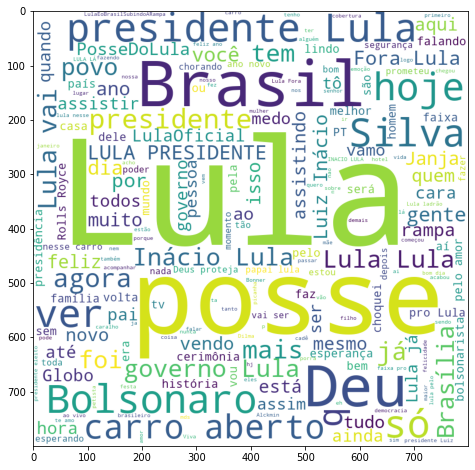

In [ ]:
# Exibindo a nuvem de Palavras
import matplotlib.pyplot as plt

figura, eixo = plt.subplots(figsize=(8,8))
plt.imshow(nuvem_tweets)

In [ ]:
# Configurando a Pesquisa
query = "Lula  lang:pt"
data_inicio = "2023-01-01 14:00:00"
data_fim = "2023-01-01 14:30:00"

In [ ]:
# Contagem dos Tweets disponiveis na query pesquisada
response_contagem = client.get_recent_tweets_count(query, start_time=converteData(data_inicio), end_time=converteData(data_fim), granularity="day")

print('Quantidade de Tweets:' + str(response_contagem.meta['total_tweet_count']))

Quantidade de Tweets:31379


In [ ]:
# Requisição da primeira pagina
response_tweets = client.search_recent_tweets(query, max_results=100,start_time=converteData(data_inicio), end_time=converteData(data_fim),
                                       user_fields=['id','username'], expansions=['author_id','entities.mentions.username'], tweet_fields=['created_at'])
#response_tweets

In [ ]:
import networkx as nx

grafo = nx.DiGraph()
data = []
usuarios = [] 


#Requisição da primeira pagina
response_tweets = client.search_recent_tweets(query, max_results=100,start_time=converteData(data_inicio), end_time=converteData(data_fim),
                                       user_fields=['id','username'], expansions=['author_id','entities.mentions.username'], tweet_fields=['created_at'])

#Gravando a ID e username dos autores dos Tweets
for user in response_tweets.includes['users']:
    users_dict = {}
    users_dict[0] = user['id']
    users_dict[1] = user['username']
    usuarios.append(users_dict)

# Gravando os Tweets coletados na primeira pagina
for tweet in response_tweets.data:
        data.append([tweet.author_id, tweet.created_at, tweet.edit_history_tweet_ids, tweet.id, tweet.text])
        if "entities" in tweet:
          for mencao in tweet.entities['mentions']:            
              # Buscando o user_name do autor do Tweet
              username_autor_tweet = list(filter(lambda usuario: usuario[0] == tweet.author_id, usuarios))[0][1]
              # Criando uma aresta do autor Tweet para o(s) usuário(s) citado(s)
              grafo.add_edge(username_autor_tweet,mencao['username'])

            
            
# Iterando enquanto houver mais resultados disponiveis, ou seja, uma proxima pagina        
while ("next_token" in response_tweets.meta):
    response_tweets = client.search_recent_tweets(query, next_token=response_tweets.meta['next_token'], max_results=100,
                                           start_time=converteData(data_inicio), end_time=converteData(data_fim),user_fields=['id','username'], 
                                           expansions=['author_id','entities.mentions.username'], tweet_fields=['created_at'])
    # Gravando a ID e username dos autores dos Tweets
    for user in response_tweets.includes['users']:
        users_dict = {}
        users_dict[0] = user['id']
        users_dict[1] = user['username']
        usuarios.append(users_dict)
    
    for tweet in response_tweets.data:
        data.append([tweet.author_id, tweet.created_at, tweet.edit_history_tweet_ids, tweet.id, tweet.text])
        if "entities" in tweet:
          for mencao in tweet.entities['mentions']:            
              # Gravando a ID e username dos autores dos Tweets
              username_autor_tweet = list(filter(lambda usuario: usuario[0] == tweet.author_id, usuarios))[0][1]
              # Criando uma aresta do autor Tweet para o(s) usuário(s) citado(s)
              grafo.add_edge(username_autor_tweet,mencao['username'])

            
# Exportando o grafo para um arquivo            
nx.write_graphml_lxml(grafo, "grafo_extracao.graphml")        
 

df_tweets = pd.DataFrame(data, columns = ['author_id','created_at','edit_history_tweet_ids','id','text'])

In [ ]:
df_tweets.head(10)